In [10]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from PIL import Image

import numpy as np
import pandas as pd
import os
import random
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [11]:
ikea_data = pd.read_csv('data/ikea_products.csv', index_col=False)
hipvan_data = pd.read_csv('data/hipvan_products.csv', index_col=False)

ikea_category = list(ikea_data.category_name.unique())
hipvan_category = list(hipvan_data.category.unique())
all_category = ikea_category + hipvan_category

# Prepare the training folder and image file list
image_folder_name = ['ikea_image', 'hipvan_image']
image_file_path = []

for folder_name in image_folder_name:
    for subfolder in all_category:
        try:
            file_list = os.listdir(folder_name + '/' + subfolder)
            for file in file_list:
                image_file_path.append(folder_name + '/' + subfolder + '/' + file)
        except:
            pass

image_file_path_df = pd.DataFrame({'image_file_path': image_file_path})
image_file_path_df['label'] = image_file_path_df.image_file_path.str.split(pat = '/').str[1]

# train_image_file_list, test_image_file_list, train_label, test_label = train_test_split(image_file_path_df.image_file_path, image_file_path_df.label, test_size=0.2, random_state=42, stratify = image_file_path_df.label)

train_image_file_list = image_file_path_df.image_file_path
train_label = image_file_path_df.label


train_image_file_list = train_image_file_list.to_list()
# test_image_file_list = test_image_file_list.to_list()



In [12]:
train_image_file_list[:10]

["ikea_image/Children's small furniture/TROFAST_Storage box_50136204.jpg",
 "ikea_image/Children's small furniture/TROFAST_Storage box_00141670.jpg",
 "ikea_image/Children's small furniture/BUSSAN_Beanbag, in_outdoor_10312911.jpg",
 "ikea_image/Children's small furniture/MAMMUT_Children_s chair_60382322.jpg",
 "ikea_image/Children's small furniture/MICKE_Desk_80354281.jpg",
 "ikea_image/Children's small furniture/AGAM_Junior chair_50253537.jpg",
 "ikea_image/Children's small furniture/TROFAST_Storage combination with boxes_s39222420.jpg",
 "ikea_image/Children's small furniture/TROFAST_Storage combination with boxes_s19335512.jpg",
 "ikea_image/Children's small furniture/TROFAST_Storage combination_s69335562.jpg",
 "ikea_image/Children's small furniture/SMÅSTAD_Wardrobe_s89389479.jpg"]

In [13]:
train_image_file_list[-10:]

['hipvan_image/kids/hipvan_98722_1.jpg',
 'hipvan_image/kids/hipvan_99809_1.jpg',
 'hipvan_image/kids/hipvan_94779_0.jpg',
 'hipvan_image/kids/hipvan_94784_0.jpg',
 'hipvan_image/kids/hipvan_82353_0.jpg',
 'hipvan_image/kids/hipvan_97066_0.jpg',
 'hipvan_image/kids/hipvan_94640_1.jpg',
 'hipvan_image/kids/hipvan_94520_0.jpg',
 'hipvan_image/kids/hipvan_89111_0.jpg',
 'hipvan_image/kids/hipvan_100506_1.jpg']

In [14]:
vgg_model = vgg16.VGG16(weights='imagenet', include_top=True)
# vgg_model.summary()

# Define VGG extracting block5_conv3 layer coefficients
vgg_model_extract_blk5conv3 = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('block5_conv3').output)

# display function to show image
def display_img(img,cmap=None):
    fig = plt.figure(figsize = (12,12))
    plt.axis(False)
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap)
    
def extract_vgg_conv_feature_from_list(image_file_list, mode='sum'):
    all_feature = []
    for idx, eachFile in enumerate(image_file_list):
        if ((idx % 100) ==0 ):
            print("process %d/%d file" % (idx+1, len(image_file_list)))
            
        img = image.load_img(eachFile, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        conv_features = vgg_model_extract_blk5conv3.predict(x)
        if (mode == 'sum'):
            conv_features = np.sum(conv_features, axis=(1,2))
            conv_features = conv_features/np.linalg.norm(conv_features) # normalzie features
        else:
            print('extract_vgg_conv_feature_from_list: Wrong mode as input')
            break
        all_feature.append(conv_features)
    return all_feature

def extract_vgg_conv_feature_from_image(image):
    all_feature = []
    x = Image.fromarray(image).resize(size=(224,224))
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    conv_features = vgg_model_extract_blk5conv3.predict(x)

    conv_features = np.sum(conv_features, axis=(1,2))
    conv_features = conv_features/np.linalg.norm(conv_features) # normalzie features
    all_feature.append(conv_features)
    
    return all_feature

def cal_vec_dist(vec1, vec2):
    '''
    Description: calculate the Euclidean Distance of two vectors
    '''
    return np.linalg.norm(vec1 - vec2)

In [15]:
# # # Uncomment followings to re-calculate all features
# # Extract features from training images
# train_all_feature_vgg_conv = extract_vgg_conv_feature_from_list(train_image_file_list, 'sum')
# np.save('data/train_all_feature_vgg_conv.npy', train_all_feature_vgg_conv)
# print("Train_all_feature_vgg_conv: (%d, %d)" % (len(train_all_feature_vgg_conv), train_all_feature_vgg_conv[0].shape[1]))



In [16]:
# Use the pre-calculated features provided in the workshop

train_all_feature_vgg_conv = np.load('data/train_all_feature_vgg_conv.npy')
# print("Train_all_feature_vgg_conv: (%d, %d)" % (len(train_all_feature_vgg_conv), train_all_feature_vgg_conv[0].shape[1]))




In [22]:
def search_image_path(image, return_top = 5):
    test_img_feature = extract_vgg_conv_feature_from_list(image)#[0]

    top_return = 5
    dist_list = []
    final_filename = []
    final_path = []
    for eachpic in range(len(train_all_feature_vgg_conv)):
        dist = cal_vec_dist(test_img_feature, train_all_feature_vgg_conv[eachpic])
        dist_list.append(dist)
        final_path.append(train_image_file_list[eachpic])
        final_filename.append(train_image_file_list[eachpic].split('/')[2])
    result = pd.DataFrame({'dist': dist_list, 'filename': final_filename, 'path': final_path})
    result = result.sort_values(by='dist').drop_duplicates('filename')
    return result[:return_top].path.tolist()


In [21]:
def search_image(image, return_top = 5):
    test_img_feature = extract_vgg_conv_feature_from_image(image)#[0]

    top_return = 5
    dist_list = []
    final_filename = []
    final_path = []
    for eachpic in range(len(train_all_feature_vgg_conv)):
        dist = cal_vec_dist(test_img_feature, train_all_feature_vgg_conv[eachpic])
        dist_list.append(dist)
        final_path.append(train_image_file_list[eachpic])
        final_filename.append(train_image_file_list[eachpic].split('/')[2])
    result = pd.DataFrame({'dist': dist_list, 'filename': final_filename, 'path': final_path})
    result = result.sort_values(by='dist').drop_duplicates('filename')
    return result[:return_top].path.tolist(), result[:return_top].dist.tolist()


In [25]:
len(train_all_feature_vgg_conv)

24304

In [26]:
len(train_image_file_list)

24304

In [23]:
test_img = cv2.cvtColor(cv2.imread('ikea_image/Storage solution systems/ELVARLI_Bracket for post_80296173.jpg'), cv2.COLOR_BGR2RGB)

In [24]:
path, dist = search_image(test_img)
print(path)
print(dist)

['ikea_image/Storage solution systems/ELVARLI_Bracket for post_80296173.jpg', 'hipvan_image/lifestyle-all/hipvan_82689_1.jpg', 'hipvan_image/decor/hipvan_100534_1.jpg', 'hipvan_image/kitchen/hipvan_93837_1.jpg', 'hipvan_image/kids/hipvan_96126_1.jpg']
[0.3922300934791565, 0.8858159780502319, 0.8865329623222351, 0.8891648054122925, 0.8902909755706787]


In [21]:
search_image(test_img)[1].split('/')[-1].strip('.jpg').split('_')[-1]

'80245918'

In [18]:
all_data[all_data.id == search_image(test_img)[1].split('/')[-1].strip('.jpg').split('_')[-1]].pipUrl.iloc[0]

IndexError: single positional indexer is out-of-bounds

In [197]:
Image.fromarray(img_w_label)

x = image.load_img('img_filename.jpg', target_size=(224, 224))
# x = image.img_to_array(x)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
# display_img(x)

# cv2.cvtColor(src, cv2.COLOR_BGR2GRAY )

In [233]:
search_image_path(['img_filename.jpg'])

process 1/1 file


['ikea_image/Blankets & throws/VITMOSSA_Throw_70304890.jpg',
 'ikea_image/Bedding/STRANDMOLKE_Duvet, light warm_70457208.jpg',
 'ikea_image/Chairs, stools & benches/BRÅTHULT_Cover for 3-seat sofa_90336183.jpg',
 'ikea_image/Sofas/GRÖNLID_Cover for 4-seat sofa_s39255967.jpg',
 'ikea_image/Sofas/GRÖNLID_2-seat sofa-bed section_s59277223.jpg']

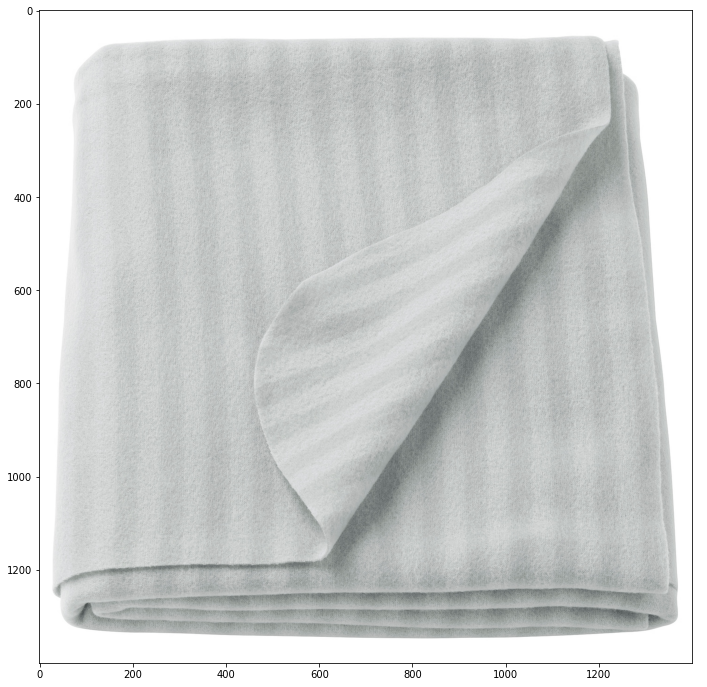

In [168]:
result = cv2.cvtColor(cv2.imread(search_image(query)[1]), cv2.COLOR_BGR2RGB)
display_img(result)

In [143]:
all_data[all_data.id == '70363969'].pipUrl.iloc[0]

'https://www.ikea.com/sg/en/p/sandared-pouffe-dark-blue-70363969/'

In [145]:
result = search_image(query)

process 1/1 file


In [157]:
all_data[all_data.id == result[1].split('/')[-1].strip('.jpg').split('_')[-1]].pipUrl.iloc[0]

'https://www.ikea.com/sg/en/p/ektorp-footstool-remmarn-light-grey-s29319922/'